In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

In [3]:
np.random.seed(123)

# create data set
n = 1000
_mus = np.array([[0,4], [-2,0]])
_sigmas = np.array([[[3, 0], [0, 0.5]], [[1,0],[0,2]]])
_pis = np.array([0.6, 0.4])
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n))
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])

# initial guesses for parameters
pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)

In [81]:
def em_gmm_thomas(X, pi, mu, sigma, eps=0.01, max_iter=100):
    N, M = X.shape
    K = len(pi)
    ll_old = 0
    
    for i in range(max_iter):
        #### E-Step ####
        gamma = np.zeros((K, N))
        for k in range(K):
            gamma[k] = pi[k] * mvn(mean=mu[k], cov=sigma[k]).pdf(X)
        gamma /= gamma.sum(0)
        
        #### M-Step ####
        # Update mass vector
        mass = gamma.sum(axis=1) 
        
        # Update means
        mu = np.dot(gamma, X) / mass
        
        # Update weights
        pi = mass / N
        
        # Update covariance matrices
        sigma = np.zeros((K, M, M))
        for k in range(K):
            for i in range(N):
                ys = np.reshape(X[i] - mu[k], (2,1))
                sigma[k] += gamma[k, i] * np.dot(ys, ys.T)
            sigma[k] /= mass[k]
                
        # Compute log-likelihood
        ll_new = 0
        for p, m, s in zip(pi, mu, sigma):
            ll_new += p * mvn(m, s).pdf(X)
        ll_new = np.log(ll_new).sum()

        print("log-likelihood:", ll_new)
        # Check if converged
        if abs(ll_new - ll_old) < eps: 
            break
        ll_old = ll_new
    
    return ll_new, pi, mu, sigma

In [82]:
%%time
ll1, pis1, mus1, sigmas1 = em_gmm_thomas(xs, pis, mus, sigmas)

log-likelihood: -4212.043712449451
log-likelihood: -4032.114397179818
log-likelihood: -4004.2381869115698
log-likelihood: -3977.8813697947307
log-likelihood: -3937.747403586857
log-likelihood: -3874.557562919731
log-likelihood: -3819.3804686303693
log-likelihood: -3805.3743691801747
log-likelihood: -3797.409760379128
log-likelihood: -3797.348479288399
log-likelihood: -3799.230448468869
log-likelihood: -3801.1601887893794
log-likelihood: -3802.299812517039
log-likelihood: -3802.8236820074753
log-likelihood: -3803.007949853206
log-likelihood: -3803.043675700495
log-likelihood: -3803.0268548549175
log-likelihood: -3802.9982412488744
log-likelihood: -3802.9722511732216
log-likelihood: -3802.9524302015884
log-likelihood: -3802.938466966601
log-likelihood: -3802.929040423406
CPU times: user 379 ms, sys: 14.2 ms, total: 393 ms
Wall time: 386 ms


In [76]:
from numpy.core.umath_tests import matrix_multiply as mm
def em_gmm_vect(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)
    ll_old = 0
    for i in range(max_iter):
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(k):
            ws[j, :] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs)
        ws /= ws.sum(0)

        # M-step
        pis = ws.sum(axis=1) / n
        
        mus = np.dot(ws, xs) / ws.sum(1)

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        # update complete log likelihoood
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi*mvn(mu, sigma).pdf(xs)
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
        print(ll_new)

    return ll_new, pis, mus, sigmas

In [77]:
%%time
ll1, pis1, mus1, sigmas1 = em_gmm_vect(xs, pis, mus, sigmas)

-4212.043712449451
-4032.114397179818
-4004.2381869115698
-3977.8813697947307
-3937.747403586857
-3874.557562919731
-3819.3804686303693
-3805.3743691801747
-3797.409760379128
-3797.348479288399
-3799.230448468869
-3801.1601887893794
-3802.299812517039
-3802.8236820074753
-3803.007949853206
-3803.043675700495
-3803.0268548549175
-3802.9982412488744
-3802.9722511732216
-3802.9524302015884
-3802.938466966601
CPU times: user 372 ms, sys: 12.1 ms, total: 384 ms
Wall time: 377 ms


/Users/thomasnilsson/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'N'
  s)


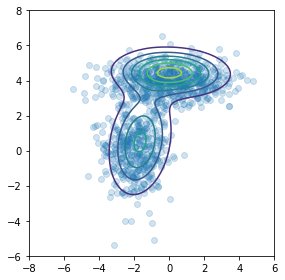

In [83]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis1, mus1, sigmas1):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()
plt.show()

In [11]:
A = np.random.rand(3,3)

In [25]:
A.sum(1)[:, None].shape

(3, 1)

In [42]:
A[0, :, None]

array([[0.79465581],
       [0.84795302],
       [0.54001702]])

In [78]:
A.sum(1)

array([2.18262586, 1.38949995, 2.12567612])

In [80]:
A[0].sum()

2.1826258579885356